<a href="https://colab.research.google.com/github/melissaortegaa/monografia/blob/main/04_transfer_learning_resnet50v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

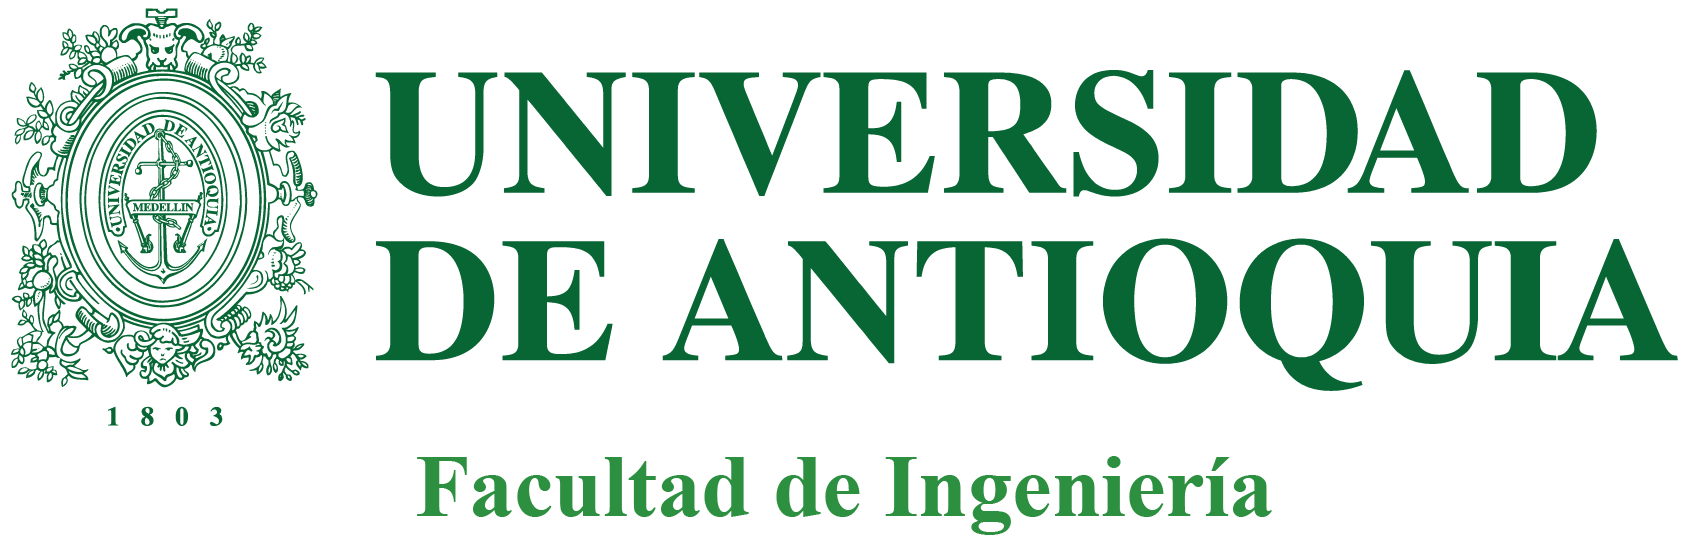
---

**Especialización en Analítica y Ciencia de Datos - Analytics & Data Science**

**Universidad de Antioquia**

**2024**

**Melissa Ortega Alzate**

---

# Exploración de las Redes neuronales convolucionales para la detección de Salmonella *spp.* en aves de corral
### Exploration of Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry

This notebook is the fourth part of a series of four notebooks associated with the project "Exploration of Convolutional Neural Networks for the Detection of Salmonella spp. in Poultry". The other notebooks can be found in the associated GitHub repository linked below.

<div style="display: flex; align-items: center; justify-content: flex-end; position: fixed; bottom: 10px; right: 10px;">
  <a href="https://colab.research.google.com/github/tu-usuario/tu-repositorio" style="margin-right: 15px;">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 25px;">
  </a>
  <a href="https://github.com/melissaortegaa/monografia" style="margin-right: 15px;">
    <img src="https://img.shields.io/badge/GitHub-000?logo=github&logoColor=fff&style=flat" alt="View on GitHub" style="height: 25px;">
  </a>
</div>

## Objective
Train an image classification model using the pre-trained ResNet50v2 convolutional neural network on feacal poultry images. The model distinguishes between healthy and Salmonella.

## Summary
This notebook covers:


1. Data Preprocessing: Preparing images with techniques like data augmentation.
2. Initial Training: extraact images characteristics using the ResNet50v2 network on the training set and evaluating on the validation set.
3. Fine-tuning: Unfreezing specific layers for improved Salmonella classification.
4. Model Evaluation: Assessing the model's performance with confusion matrix visualization and metric comparison, including the test set.




# Init

### Imports

In [ ]:
# Standard library imports
import os
import sys
import random
import zipfile
import warnings
import time
import math
from pathlib import Path

# Visualization
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Data manipulation and processing
import numpy as np
import pandas as pd

# Deep learning frameworks and utilities
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import backend as K

# Callbacks, regularizer and optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam

# Keras tuner
!pip install keras-tuner -q
import keras_tuner
from keras_tuner.applications import HyperResNet

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Ignore Warnings
warnings.filterwarnings("ignore")

# Clear any previous Keras session to avoid clutter from old models
K.clear_session()

# Confirmation
print('\nThe modules were successfully loaded.')

2024-06-03 22:21:58.422700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 22:21:58.422830: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 22:21:58.528989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



The modules were successfully loaded.


In [ ]:
# Google Drive connection
!pip install -q gdown
import gdown
print('gdown was successfully installed and imported.')

gdown was successfully installed and imported.


### Tensorflow and devices settings

In [ ]:
# System configuration
if 'google.colab' in sys.modules:
    print("Setting TensorFlow version in Colab")
    %tensorflow_version 2.x

# Check TensorFlow version
print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.15.0


In [ ]:
# GPU configuration
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU.')
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpu_devices)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print('Using CPU.')

Using GPU.
1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Hardware devices info
!nvidia-smi

Mon Jun  3 22:22:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              33W / 250W |    256MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Fixing the random seeds for reproducibility
np.random.seed(0)         # NumPy random seed
tf.random.set_seed(0)     # TensorFlow random seed
random.seed(0)            # Python random seed

print("Random seeds are set for reproducibility.")

Random seeds are set for reproducibility.


# Functions

**Function to plot activation maps of a given model layer**

In [ ]:
# Function to plot activation maps of a given model layer
def plot_activations(model, layer_name,image_batch,label_batch, n_images=5, n_channels=10):
    """
    Plots the activations of a given intermediate layer for a batch of input images.

    Parameters:
    model: keras.Model - The model to extract the activations from.
    layer_name: str - The name of the intermediate layer to extract the activations from.
    train_generator: keras.utils.Sequence - The data generator for providing input images.
    n_images: int, optional - The number of input images to plot the activations for. Default is 5.
    n_channels: int, optional - The number of channels to plot. Default is 10.

    Returns:
    fig: matplotlib.figure.Figure - The figure containing the activation plots.
    """
    # Create a new model that includes the model and the intermediate layer
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    # Ensure we only process the desired number of images
    image_batch = image_batch[:n_images]
    label_batch = label_batch[:n_images]

    # Print labels to check for variety
    print("Labels of selected images:", label_batch)

    # Extract the activations of the intermediate layer for the input images
    activations = intermediate_layer_model.predict(image_batch)
    num_channels = min(activations.shape[-1], n_channels)

    # Plot the activations for a subset of the input images
    fig, axes = plt.subplots(n_images, num_channels + 1, figsize=(2 * (num_channels + 1), 2 * n_images))
    for i in range(n_images):
        ax = axes[i, 0]
        ax.imshow(image_batch[i])
        ax.axis("off")
        for j in range(num_channels):
            ax = axes[i, j + 1]
            act = activations[i, :, :, j]
            ax.imshow(act, cmap=plt.cm.Greys_r)
            ax.axis("off")
    return fig

**Function to plot history of training**

In [ ]:
# Function to plot history of training
def plot_history(metrics, title='Model training history',tunning=False):
    """
    Function to plot the training history of a model.

    Parameters:
    history: History object returned by the Keras fit method.
    title (str): Title for the plot.

    """
    metrics['epoch'] = history.epoch

    # Plot learning curves
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    metrics_names = ['loss', 'accuracy', 'recall','auc']
    metrics_titles = ['Loss', 'Accuracy', 'Recall', 'AUC']

    # Create the fig
    for i, metric in enumerate(metrics_names):
        # Best epoch
        if metric =='val_loss':
            value_index = metrics[f'val_{metric}'].idxmin()
            value = metrics[f'val_{metric}'].min()
        else:
            value_index = metrics[f'val_{metric}'].idxmax()
            value = metrics[f'val_{metric}'].max()

        index = metrics['epoch'][value_index]
        label = f'best epoch= {str(index + 1)}'

        # Plot
        ax = axes.flat[i]
        ax.plot(metrics[metric], 'o-r')
        ax.plot(metrics[f'val_{metric}'], '--')
        ax.scatter(index, value, s=60, c='green')
        ax.set(ylabel=metrics_titles[i])
        ax.set(title=metrics_titles[i])
        ax.legend(['Train', 'Validation', label])
        ax.set_ylim([metrics[metric].min() - 0.1])
        ax.set(xlabel="Epochs")

        if tunning:
            ax.axvline(EPOCHS, ls='--', lw=1, c='grey')
            ax.legend(['Train', 'Validation', label,'Fine tuning'])

    # Styling
    fig.suptitle(title, fontsize = 12, weight='bold')
    plt.tight_layout()
    plt.show()

    # Adjust space between subplots and title
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Show the plot
    plt.show();

**Function to create confusion matrix**

In [ ]:
# Function to create confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """
    This function prints and plots the confusion matrix.
    """
    # Calcualte the cm
    cm = confusion_matrix(y_true, y_pred)

    # Create the fig
    fig, ax = plt.subplots(figsize=(4, 3))
    fig = sns.heatmap(cm,
                      cmap=plt.cm.YlGnBu,
                      linewidths=.5,
                      cbar=True,
                      fmt='.0f',
                      annot=True,
                      xticklabels=['Healthy', 'Salmonella'],
                      yticklabels=['Healthy', 'Salmonella'])

    # Styling
    plt.title('Confusion matrix', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.ylabel('True label', fontsize=10)
    plt.show()

    return fig

**Funtion to plot sample images**

In [ ]:
def show_images(generator):
    '''
    This function take the data generator and show sample of the images
    '''
    # return classes , images to be displayed
    g_dict = generator.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(generator)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'red' if class_name == 'salmo' else 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

# Load the dataset

In [ ]:
# Download the preprocessed zip file from Google Drive
!gdown '13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp' -O \
    /tmp/data1.zip

Downloading...
From (original): https://drive.google.com/uc?id=13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp
From (redirected): https://drive.google.com/uc?id=13G-XzLgJx_94ZER7yT1j4lCK_srx2jQp&confirm=t&uuid=dd749c4f-b176-4c32-9f7a-18fd04f808c9
To: /tmp/data1.zip
100%|█████████████████████████████████████████| 172M/172M [00:01<00:00, 170MB/s]


In [ ]:
# Define the path of the ZIP file and the extraction directory
local_zip = '/tmp/data1.zip'
extract_dir = '/tmp/data'

# Extract files from the ZIP archive
try:
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print("Extraction completed successfully.")
except Exception as e:
    print("Error during extraction:", e)

Extraction completed successfully.


In [ ]:
# Define directories
base_dir = '/tmp/data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Define subdirectories for each class
train_healthy_dir = os.path.join(train_dir, 'healthy')
train_salmo_dir = os.path.join(train_dir, 'salmo')

validation_healthy_dir = os.path.join(validation_dir, 'healthy')
validation_salmo_dir = os.path.join(validation_dir, 'salmo')

test_healthy_dir = os.path.join(test_dir, 'healthy')
test_salmo_dir = os.path.join(test_dir, 'salmo')

# Get lists of files in each folder
train_healthy_fnames = os.listdir(train_healthy_dir)
train_salmo_fnames = os.listdir(train_salmo_dir)

validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_salmo_fnames = os.listdir(validation_salmo_dir)

test_healthy_fnames = os.listdir(test_healthy_dir)
test_salmo_fnames = os.listdir(test_salmo_dir)

# Print example files names
print(f"Train data examples for 1st class: \n{train_healthy_fnames[:10]}")
print(f"\nTrain data examples for 2nd class: \n{train_salmo_fnames[:10]}")

Train data examples for 1st class: 
['healthy.1251.jpg', 'healthy.1036.jpg', 'healthy.1514.jpg', 'healthy.2004.jpg', 'pcrhealthy.309.jpg', 'healthy.1977.jpg', 'healthy.46.jpg', 'healthy.1989.jpg', 'healthy.1407.jpg', 'healthy.362.jpg']

Train data examples for 2nd class: 
['salmo.1882.jpg', 'salmo.943.jpg', 'salmo.676.jpg', 'salmo.1273.jpg', 'salmo.800.jpg', 'salmo.1599.jpg', 'salmo.1287.jpg', 'salmo.2067.jpg', 'salmo.2092.jpg', 'salmo.117.jpg']


# Data preprocessing and augmentation

In this section, three main transformations are applied to the training and validation images:

* Resizing: All images are resized to 224x224x3.
* Scaling and normalization: according to ResNet50v2 preprocess_input transformations.
* Augmentation: Rotations, shears, zooms, and flips are added to the training data.

In [ ]:
# Define training parameters
IMG_SIZE = 224
EPOCHS = 50          # Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
STEPS_PER_EPOCH = 20 # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch
BATCH_SIZE = 64      # Number of samples per gradient update
VALIDATION_STEPS = 10

In [ ]:
# Transforms will be added to the images to increase the size of the datasets.
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

validation_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Flow training images in batches using train_datagen generator for categorical models.
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        seed=42)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        seed=42)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        color_mode='rgb',
        shuffle=False,  # No shuffle for test data
        seed=42)

Found 4023 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


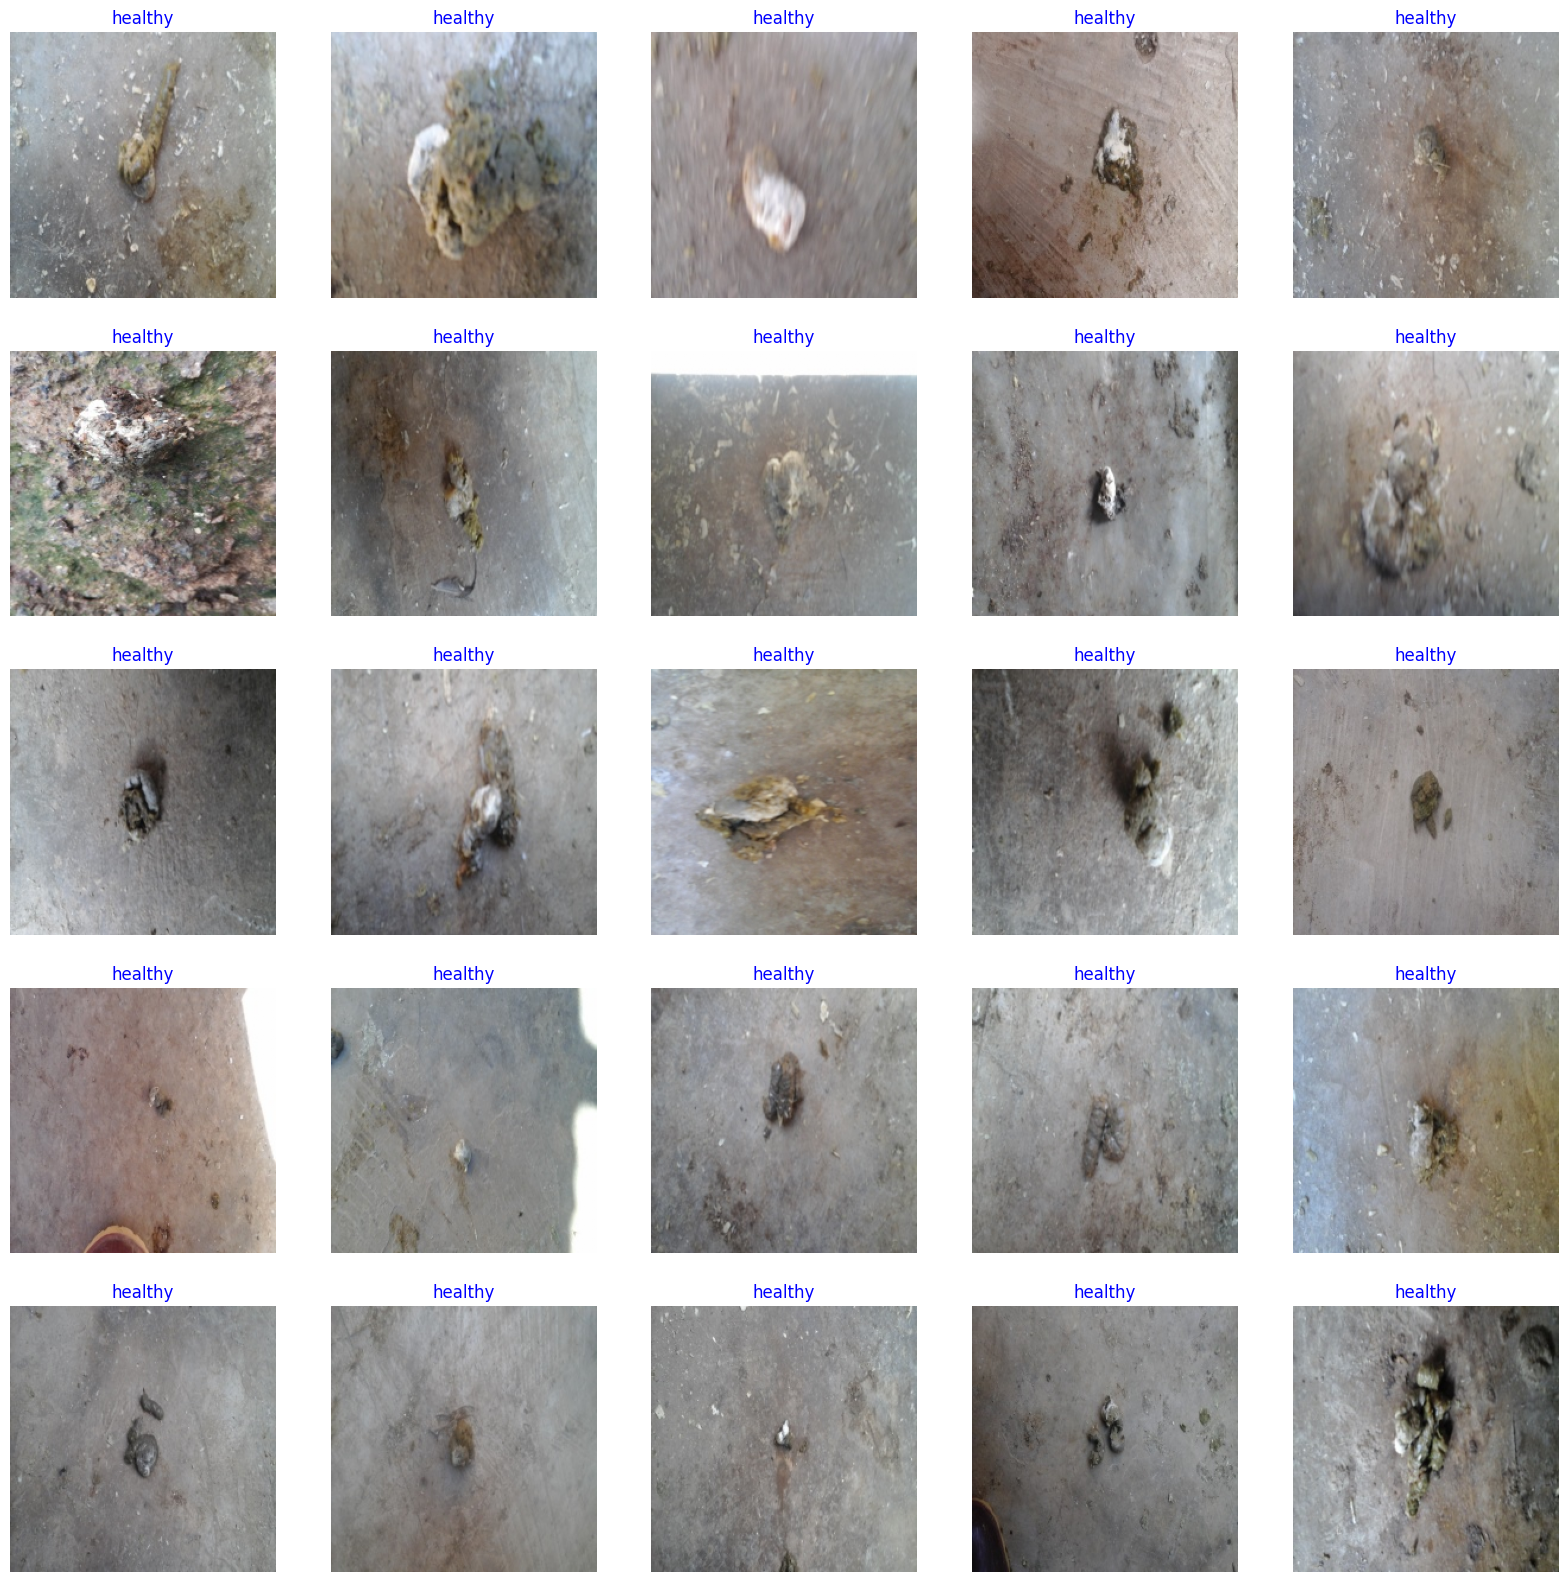

In [ ]:
# Visualize sample images after preprocessing and data augmentation
show_images(test_generator)

# ResNet50V2 transfer learning

In [ ]:
# Create the base model from the pre-trained model ResNet50v2 without top layers

base_model = ResNet50V2(weights='imagenet',         # Load weights pre-treined on ImageNet
                        include_top=False,          # Do nor include the ImageNet classifier at the top
                        input_shape=(IMG_SIZE, IMG_SIZE, 3),
                        )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze the convolutional base layers to avoid them to update the weights during the training
base_model.trainable = False
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Obtain a batch of images and labels from the training generator
image_batch, label_batch = next(train_generator)

# Verify that the input shape matches the shape of the images in the batch
print("Input shape:", base_model.input_shape)
print("Image batch shape:", image_batch.shape)

# Pass the batch of images through the ResNet50v2 model and obtain the feature vectors
feature_batch = base_model(image_batch)

# Print the shape of the feature vectors
print("Feature batch shape:", feature_batch.shape)

Input shape: (None, 224, 224, 3)
Image batch shape: (64, 224, 224, 3)
Feature batch shape: (64, 7, 7, 2048)


This pre-trained model is used as a feature extractor, it converts each 224x224x3 image into a 7x7x512 block of features. An the end 64 characteristics maps are generated. That output will be then used to train some top layers on the dataset to get the predictions.

Labels of selected images: [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1717453397.964848     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


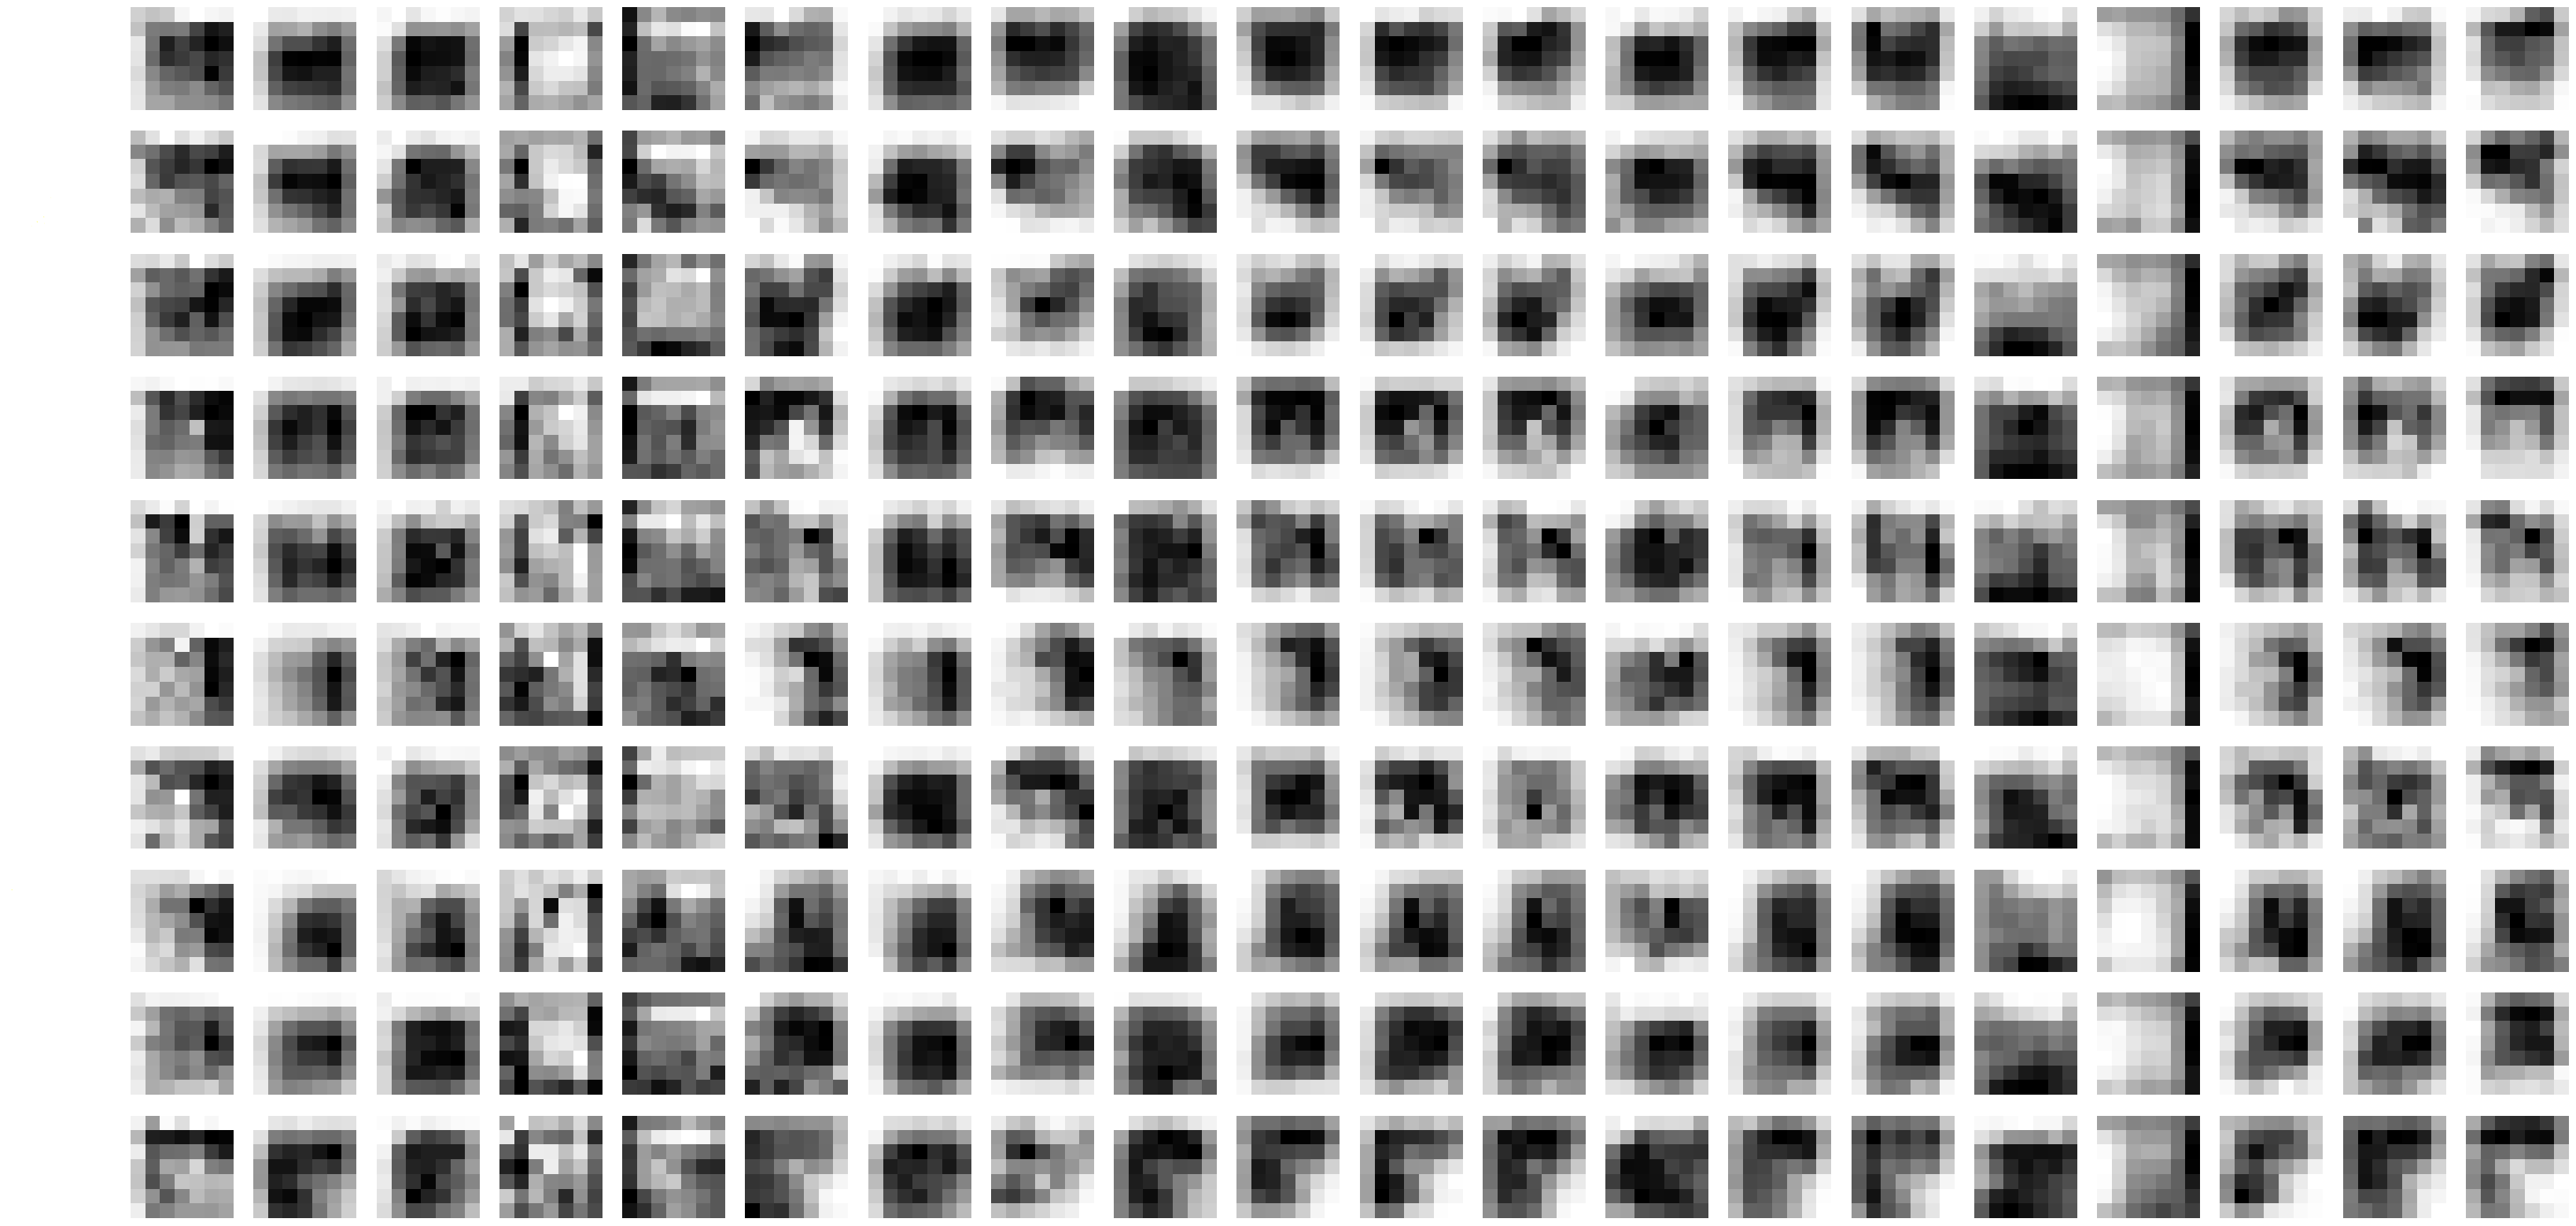

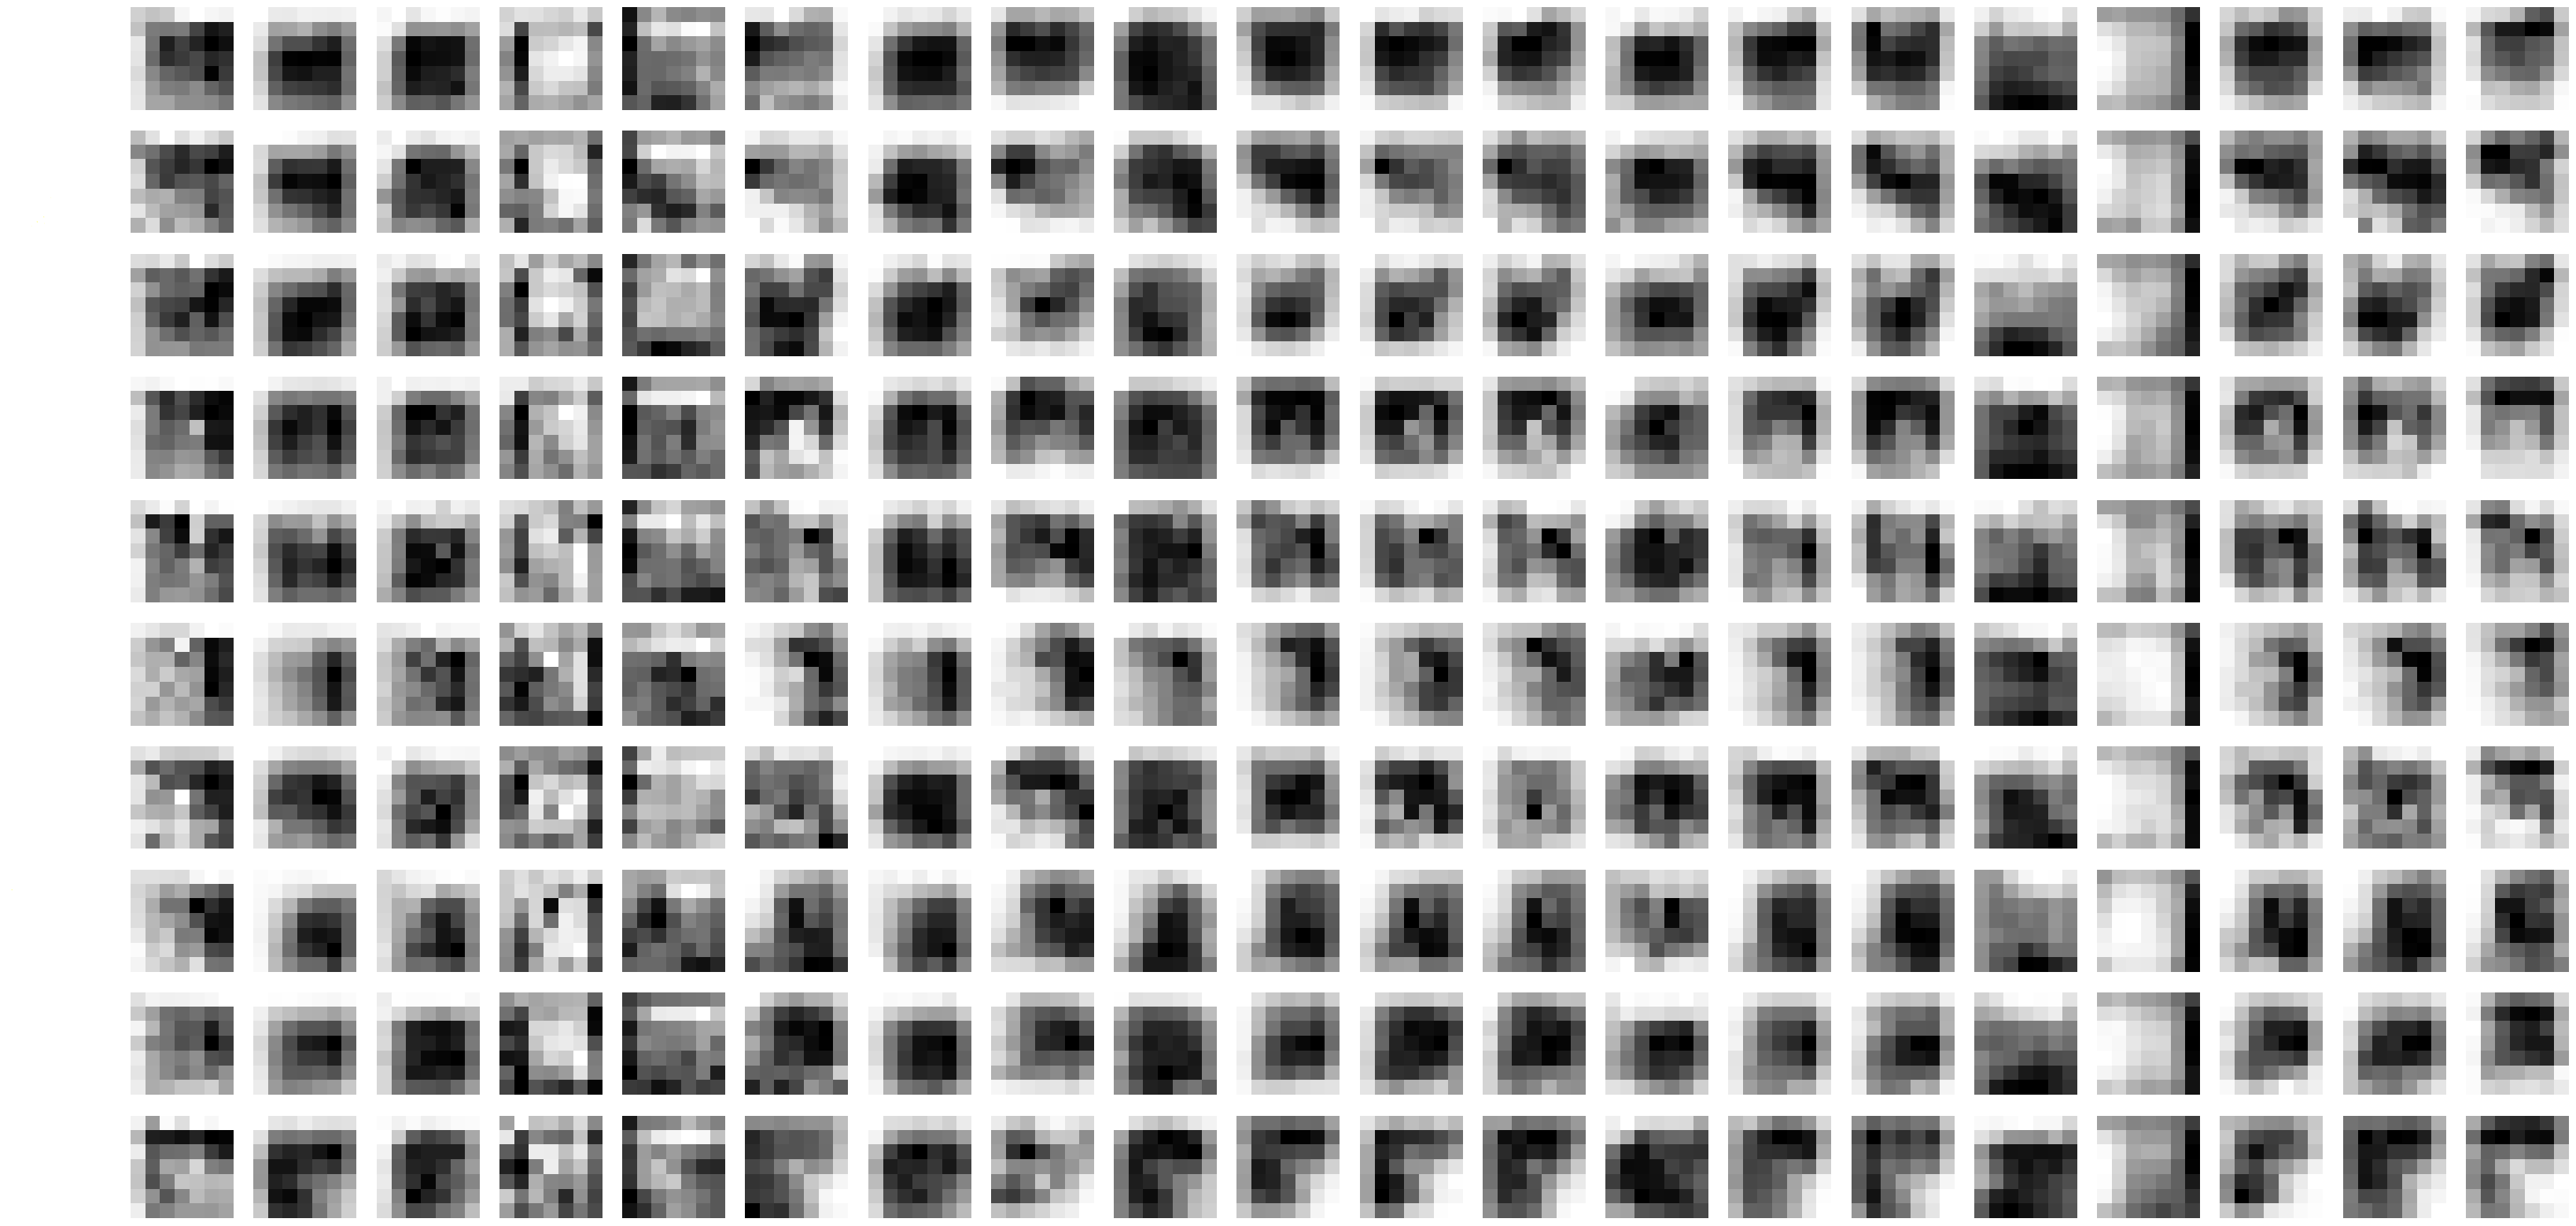

In [ ]:
# Plot activations
image_batch, label_batch = next(train_generator)
plot_activations(base_model, 'conv5_block3_out', image_batch, label_batch, n_images=10, n_channels=20)


## Add new layers to the ResNet50v2 model

Using Keras’ functional API to define the ResNet50v2 output as input into a new set of fully-connected layers like so:

In [ ]:
# Adding top custom Layers
x = base_model.output

# Convert features of shape 'base_model.output_shape[1:]' to vectors
x = GlobalAveragePooling2D()(x)

# Adding a dense and dropout layer
x = Dense(512, activation='relu', name='dense')(x)
x = Dropout(0.5, seed=42)(x)

# Adding a dense classifier with softmax activation
output = Dense(2, activation='softmax',name='output')(x)

In [ ]:
# Define the new model
transfer_model = Model(inputs=base_model.input, outputs=output)
transfer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,614,914 (93.90 MB)

 Trainable params: 1,050,114 (4.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Compile the model using the best baseline parameters
transfer_model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.0001),
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

### Callbacks

In [ ]:
# Define early stopping parameters
earlystop = EarlyStopping(monitor='val_loss',mode= 'min',patience=20, verbose=1, restore_best_weights=True)

# Define the ModelCheckpoint callback to save the best model based on the validation metric
checkpoint = ModelCheckpoint('best_resnet50_model.keras', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

### Train the transfer model

In [ ]:
# Train the transfer model
history = transfer_model.fit(train_generator,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = EPOCHS,
                            validation_data = validation_generator,
                            validation_steps = VALIDATION_STEPS,
                            verbose=1,
                            callbacks = [earlystop, checkpoint]
                            )

Epoch 1/50
 2/20 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4805 - auc: 0.4805 - loss: 83.9555 - recall: 0.4805 

W0000 00:00:1717453463.686303     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5129 - auc: 0.5145 - loss: 69.9893 - recall: 0.5129 

W0000 00:00:1717453491.180079     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5140 - auc: 0.5156 - loss: 69.5624 - recall: 0.5140 - val_accuracy: 0.7844 - val_auc: 0.8006 - val_loss: 5.4006 - val_recall: 0.7844
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6185 - auc: 0.6239 - loss: 41.4790 - recall: 0.6185 - val_accuracy: 0.7699 - val_auc: 0.7860 - val_loss: 8.2503 - val_recall: 0.7699
Epoch 3/50
 1/20 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6875 - auc: 0.6875 - loss: 22.3963 - recall: 0.6875

W0000 00:00:1717453515.078119     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 554ms/step - accuracy: 0.6875 - auc: 0.6875 - loss: 27.7788 - recall: 0.6875 - val_accuracy: 0.7344 - val_auc: 0.7475 - val_loss: 15.8291 - val_recall: 0.7344
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6922 - auc: 0.7048 - loss: 27.2559 - recall: 0.6922 - val_accuracy: 0.7965 - val_auc: 0.8210 - val_loss: 9.3782 - val_recall: 0.7965
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 853ms/step - accuracy: 0.7552 - auc: 0.7667 - loss: 17.6419 - recall: 0.7552 - val_accuracy: 0.7969 - val_auc: 0.8045 - val_loss: 9.5743 - val_recall: 0.7969
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 703ms/step - accuracy: 0.7228 - auc: 0.7310 - loss: 18.9263 - recall: 0.7228 - val_accuracy: 0.6991 - val_auc: 0.7177 - val_loss: 17.2129 - val_recall: 0.6991
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 659ms/step - accuracy: 0.7755 - auc: 0.7786 - loss: 14.0708 - recall: 0.7755 - val_accuracy: 0.7937 - val_auc: 0.8023 - val_loss: 10.2410 - val_recall: 0.7937
Epoch 8/50

## Evaluation and testing

### Histories plot

In [ ]:
# Convert the history to a DataFrame
metrics = pd.DataFrame(history.history)

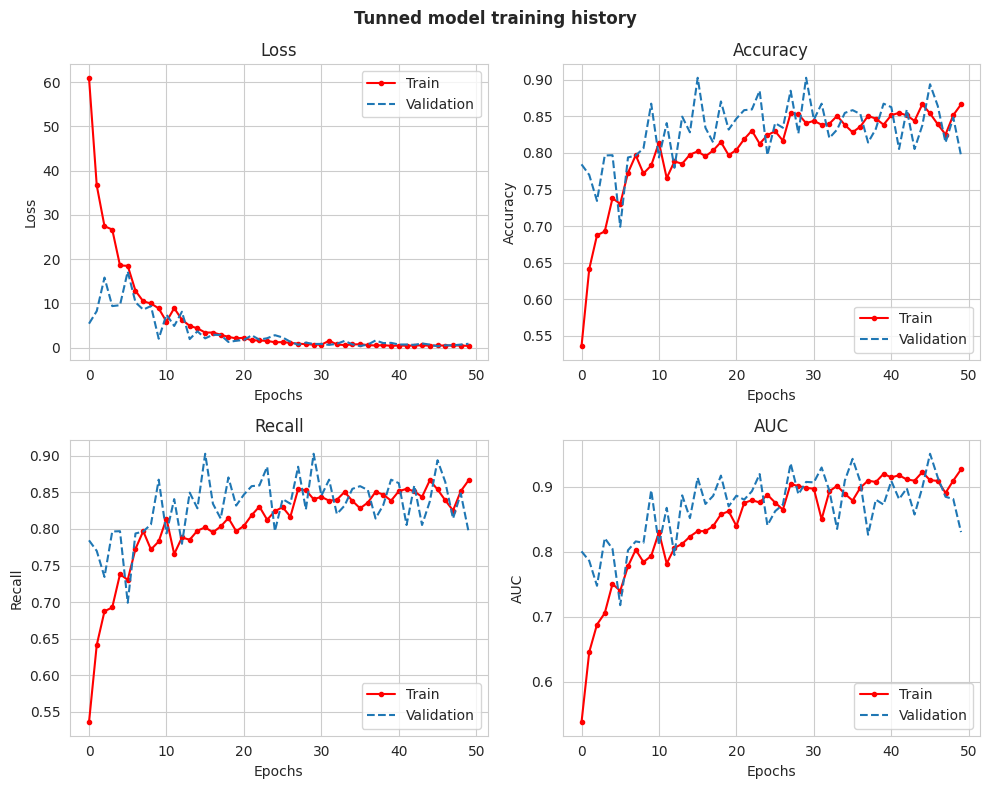

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

metrics_names = ['loss', 'accuracy', 'recall','auc']
metrics_titles = ['Loss', 'Accuracy', 'Recall', 'AUC']

# Create the fig
for i, metric in enumerate(metrics_names):
    ax = axes.flat[i]
    ax.plot(metrics[metric], 'o-r', markersize=3)
    ax.plot(metrics[f'val_{metric}'], '--')
    ax.set(ylabel=metrics_titles[i], title=metrics_titles[i])
    ax.legend(['Train', 'Validation', 'Fine tuning'])
    ax.set(xlabel="Epochs")

# Styling
fig.suptitle("Tunned model training history", fontsize = 12, weight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Display the best validation metrics

for metric in metrics.columns:
    # Check if the column is a validation metric
    if metric.startswith('val_'):
        print(f"Best validation {metric}:")
        # Get the maximum value of the metric
        best = metrics.sort_values(by=metric, ascending=False)
        # Print the result
        display(best.head(1))

Best validation val_accuracy:


accuracy       auc      loss    recall  val_accuracy   val_auc  val_loss  \
15  0.802083  0.831706  3.392806  0.802083      0.902655  0.913932  2.075774   

    val_recall  
15    0.902655

Best validation val_auc:


accuracy       auc      loss    recall  val_accuracy   val_auc  val_loss  \
45  0.853906  0.910202  0.464525  0.853906      0.893805  0.950897  0.283347   

    val_recall  
45    0.893805

Best validation val_loss:


accuracy       auc       loss    recall  val_accuracy   val_auc   val_loss  \
5  0.730469  0.739841  18.479023  0.730469      0.699115  0.717676  17.212934   

   val_recall  
5    0.699115

Best validation val_recall:


accuracy       auc      loss    recall  val_accuracy   val_auc  val_loss  \
15  0.802083  0.831706  3.392806  0.802083      0.902655  0.913932  2.075774   

    val_recall  
15    0.902655

### Confussion matrix

W0000 00:00:1717454090.738571     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


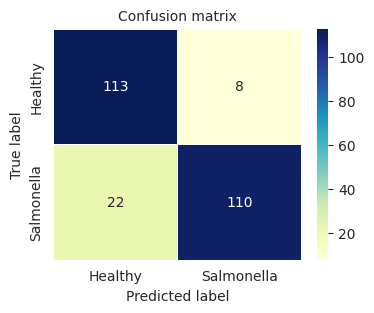

precision    recall  f1-score     support
0              0.837037  0.933884  0.882812  121.000000
1              0.932203  0.833333  0.880000  132.000000
accuracy       0.881423  0.881423  0.881423    0.881423
macro avg      0.884620  0.883609  0.881406  253.000000
weighted avg   0.886689  0.881423  0.881345  253.000000

In [ ]:
# Evaluate the model on the validation set
preds = transfer_model.predict(test_generator, verbose = 0)
y_pred = np.argmax(preds, axis=1)

# Get the true labels for the validation set
y_true = test_generator.classes

# Calculate and plot the confusion matrix
plot_confusion_matrix(y_true, y_pred);

# Calculate and plot the confusion matrix
report = classification_report(y_true, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report

## Fine-tuning weights

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# How many layers are in the base model
layer_in_base_model = len(base_model.layers)
print(f"Number of layers in the base model: {layer_in_base_model}")

# Fine-tune from this layer onwards
layer_to_unfreeze = 50
start_fine_tuning_at = layer_in_base_model - layer_to_unfreeze
print(f'Start fine tuning at: {start_fine_tuning_at}')

# Freeze all the layers before the `start_fine_tuning_at` layer
for layer in base_model.layers[:start_fine_tuning_at]:
    layer.trainable = False

tuned_model = Model(inputs=base_model.input, outputs=output)

Number of layers in the base model: 190
Start fine tuning at: 140


In [ ]:
# See how many parameters are now trainable
tuned_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,614,914 (93.90 MB)

 Trainable params: 17,402,370 (66.38 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

In [ ]:
# Define the base learning rate
base_learning_rate = 0.0001

# Compile the transfer_model with the specified configuration
tuned_model.compile(
    loss='categorical_crossentropy',
    optimizer= Adam(learning_rate=base_learning_rate / 10),  # Using Adam optimizer with a very low learning rate
    metrics=['accuracy', tf.keras.metrics.Recall(),tf.keras.metrics.AUC()]
)

In [ ]:
# Get the number of trainable variables
num_trainable_variables = len(transfer_model.trainable_variables)

Number of trainable variables: 50

List of trainable variables:


[<KerasVariable shape=(1, 1, 256, 1024), dtype=float32, path=conv4_block5_3_conv/kernel>,
 <KerasVariable shape=(1024,), dtype=float32, path=conv4_block5_3_conv/bias>,
 <KerasVariable shape=(1024,), dtype=float32, path=conv4_block6_preact_bn/gamma>,
 <KerasVariable shape=(1024,), dtype=float32, path=conv4_block6_preact_bn/beta>,
 <KerasVariable shape=(1, 1, 1024, 256), dtype=float32, path=conv4_block6_1_conv/kernel>,
 <KerasVariable shape=(256,), dtype=float32, path=conv4_block6_1_bn/gamma>,
 <KerasVariable shape=(256,), dtype=float32, path=conv4_block6_1_bn/beta>,
 <KerasVariable shape=(3, 3, 256, 256), dtype=float32, path=conv4_block6_2_conv/kernel>,
 <KerasVariable shape=(256,), dtype=float32, path=conv4_block6_2_bn/gamma>,
 <KerasVariable shape=(256,), dtype=float32, path=conv4_block6_2_bn/beta>,
 <KerasVariable shape=(1, 1, 256, 1024), dtype=float32, path=conv4_block6_3_conv/kernel>,
 <KerasVariable shape=(1024,), dtype=float32, path=conv4_block6_3_conv/bias>,
 <KerasVariable shap

### Continue training

In [ ]:
# Define the number of epochs for fine-tuning
fine_tune_epochs = 20

# Calculate the total number of including fine-tuning
total_epochs = EPOCHS + fine_tune_epochs

# Fine-tune the model
history_fine_tune = tuned_model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Resume training from the last epoch of previous training
    validation_data=validation_generator,
    callbacks=[earlystop, checkpoint]
)

Epoch 50/70
 2/63 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.4766 - auc_1: 0.5086 - loss: 0.9367 - recall_1: 0.4766 

W0000 00:00:1717454135.003246     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.6047 - auc_1: 0.6617 - loss: 0.6984 - recall_1: 0.6047

W0000 00:00:1717454189.968353     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 936ms/step - accuracy: 0.6064 - auc_1: 0.6637 - loss: 0.6962 - recall_1: 0.6064 - val_accuracy: 0.8114 - val_auc_1: 0.8736 - val_loss: 0.4989 - val_recall_1: 0.8114
Epoch 51/70


W0000 00:00:1717454192.915693     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 665ms/step - accuracy: 0.8327 - auc_1: 0.9096 - loss: 0.3849 - recall_1: 0.8327 - val_accuracy: 0.6919 - val_auc_1: 0.7932 - val_loss: 0.5410 - val_recall_1: 0.6919
Epoch 52/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 665ms/step - accuracy: 0.8794 - auc_1: 0.9511 - loss: 0.2886 - recall_1: 0.8794 - val_accuracy: 0.8752 - val_auc_1: 0.9464 - val_loss: 0.3005 - val_recall_1: 0.8752
Epoch 53/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 661ms/step - accuracy: 0.8981 - auc_1: 0.9604 - loss: 0.2555 - recall_1: 0.8981 - val_accuracy: 0.8991 - val_auc_1: 0.9649 - val_loss: 0.2409 - val_recall_1: 0.8991
Epoch 54/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 48s 679ms/step - accuracy: 0.9049 - auc_1: 0.9672 - loss: 0.2314 - recall_1: 0.9049 - val_accuracy: 0.9270 - val_auc_1: 0.9719 - val_loss: 0.2141 - val_recall_1: 0.9270
Epoch 55/70
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 660ms/step - accuracy: 0.9117 - auc_1: 0.9694 - loss: 0.2221 - recall_1: 0.9117 - val_accuracy: 0.9177 - val_auc_1: 0.9714 - val_loss: 0.

### Histories plot

In [ ]:
# Get training history into a DataFrame
metrics_tuned = pd.DataFrame(history_fine_tune.history)

# Rename columns names
metrics_tuned = metrics_tuned.rename(columns={'val_recall_1': 'val_recall',
                                              'val_auc_1': 'val_auc',
                                              'auc_1':'auc',
                                              'recall_1':'recall'})
# Concatenate the initial metrics with the fine-tuning metrics
metrics_tuned = pd.concat([metrics, metrics_tuned], ignore_index=True)

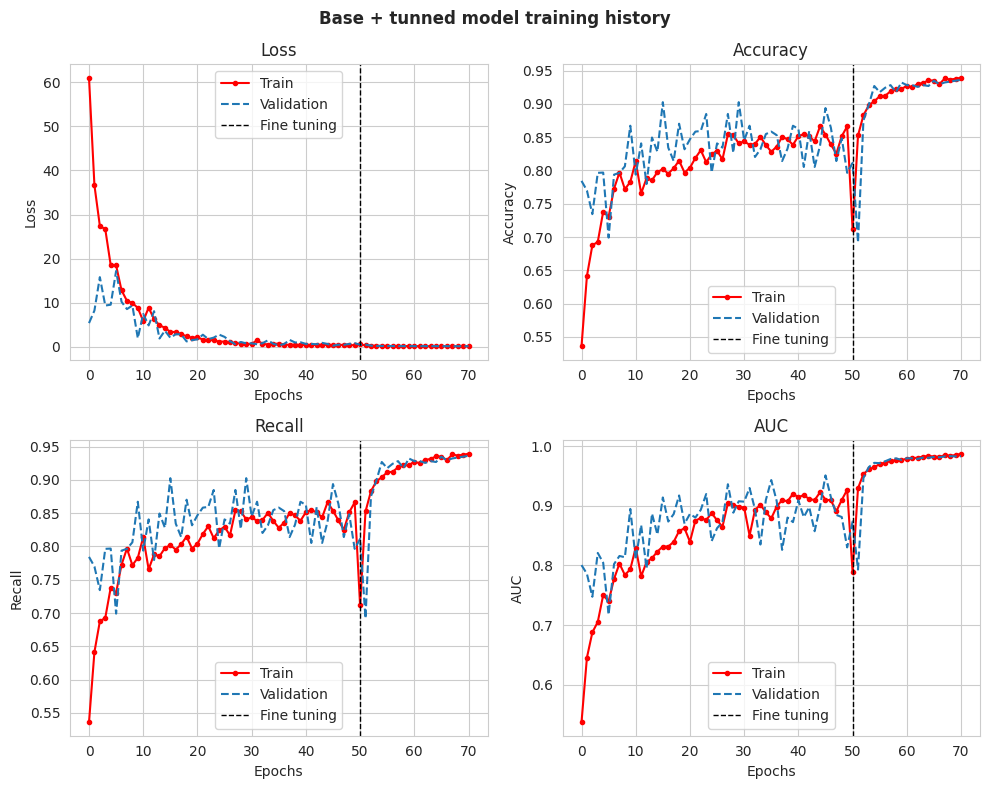

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

metrics_names = ['loss', 'accuracy', 'recall','auc']
metrics_titles = ['Loss', 'Accuracy', 'Recall', 'AUC']

# Create the fig
for i, metric in enumerate(metrics_names):
    ax = axes.flat[i]
    ax.plot(metrics_tuned[metric], 'o-r', markersize = 3)
    ax.plot(metrics_tuned[f'val_{metric}'], '--')
    ax.set(ylabel=metrics_titles[i], title=metrics_titles[i])
    ax.axvline(EPOCHS, ls='--', lw=1, c='black')
    ax.legend(['Train', 'Validation', 'Fine tuning'])
    ax.set(xlabel="Epochs")

# Styling
fig.suptitle("Base + tunned model training history", fontsize = 12, weight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Display the best validation metrics
for metric in metrics_tuned.columns:
    # Check if the column is a validation metric
    if metric.startswith('val_'):
        print(f"Best {metric}:")
        # Get the maximum value of the metric
        best = metrics_tuned.sort_values(by=metric, ascending=False)
        # Print the result
        display(best.head(1))

Best val_accuracy:


accuracy       auc     loss    recall  val_accuracy   val_auc  val_loss  \
70  0.939349  0.987087  0.14599  0.939349      0.936255  0.983044  0.164779   

    val_recall  
70    0.936255

Best val_auc:


accuracy       auc     loss    recall  val_accuracy   val_auc  val_loss  \
70  0.939349  0.987087  0.14599  0.939349      0.936255  0.983044  0.164779   

    val_recall  
70    0.936255

Best val_loss:


accuracy       auc       loss    recall  val_accuracy   val_auc   val_loss  \
5  0.730469  0.739841  18.479023  0.730469      0.699115  0.717676  17.212934   

   val_recall  
5    0.699115

Best val_recall:


accuracy       auc     loss    recall  val_accuracy   val_auc  val_loss  \
70  0.939349  0.987087  0.14599  0.939349      0.936255  0.983044  0.164779   

    val_recall  
70    0.936255

### Confussion matrix

W0000 00:00:1717455144.058525     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


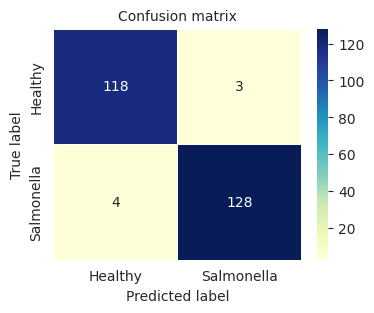

precision    recall  f1-score     support
0              0.967213  0.975207  0.971193  121.000000
1              0.977099  0.969697  0.973384  132.000000
accuracy       0.972332  0.972332  0.972332    0.972332
macro avg      0.972156  0.972452  0.972289  253.000000
weighted avg   0.972371  0.972332  0.972336  253.000000

In [ ]:
# Evaluate the model on the validation set
preds = tuned_model.predict(test_generator, verbose = 0)
y_pred = np.argmax(preds, axis=1)

# Get the true labels for the validation set
y_true = test_generator.classes

# Calculate and plot the confusion matrix
plot_confusion_matrix(y_true, y_pred);

# Calculate and plot the confusion matrix
report = classification_report(y_true, y_pred, output_dict=True)
report = pd.DataFrame(report).transpose()
report

### Validation metrics

In [ ]:
# Diccionario con los nombres de los modelos y sus respectivos modelos entrenados
models = {
    'tuned_model':tuned_model,
    'transfer_model': transfer_model,
}

In [ ]:
# Define the data splits
data_splits = ['Train', 'Validation', 'Test']

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Data Split', 'Loss', 'Accuracy', 'Recall', 'AUC','Time (s)', 'Params'])

# Evaluate the model for each data split and each model
for model_name, model in models.items():
    for split in data_splits:
        # Determine the generator to use based on the data split
        if split == 'Train':
            data_generator = train_generator
        elif split == 'Validation':
            data_generator = validation_generator
        else:
            data_generator = test_generator

        # Evaluate the model on the data split
        start_eval_time = time.time()
        score = model.evaluate(data_generator, steps=VALIDATION_STEPS, verbose=0)
        end_eval_time = time.time()
        eval_time = end_eval_time - start_eval_time
        params = model.count_params()

        # Store the results in the DataFrame
        results_df.loc[len(results_df)] = [model_name, split, score[0], score[1], score[2],score[3], eval_time, params]

# Display the results DataFrame
results_df

Model  Data Split      Loss  Accuracy    Recall       AUC  \
0     tuned_model       Train  0.115879  0.960938  0.960938  0.991697   
1     tuned_model  Validation  0.158662  0.937500  0.937500  0.983632   
2     tuned_model        Test  0.106969  0.972332  0.972332  0.994298   
3  transfer_model       Train  0.122365  0.953125  0.953125  0.990981   
4  transfer_model  Validation  0.164657  0.935938  0.935938  0.982662   
5  transfer_model        Test  0.106969  0.972332  0.972332  0.994298   

   Time (s)    Params  
0  8.686790  24614914  
1  1.356255  24614914  
2  2.855659  24614914  
3  9.096099  24614914  
4  1.552767  24614914  
5  2.459286  24614914

### ROC Curve

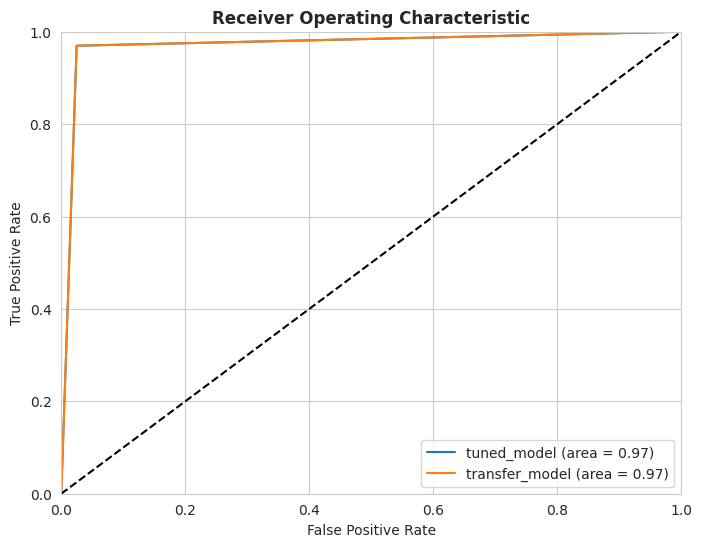

In [ ]:
# Dictionary to store predictions and true labels for each model
predictions = {}

# Get predictions and true labels for each model
for name, model in models.items():
    y_true = test_generator.classes
    y_pred = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)
    predictions[name] = (y_true, y_pred)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over the predictions and true labels for each model
for name, (y_true, y_pred) in predictions.items():
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax.plot(fpr, tpr, label=(f"{name} (area = {roc_auc:.2f})"))

# Plot the line of no discrimination
ax.plot([0, 1], [0, 1], 'k--')

# Styling
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic', weight='bold', size=12)
ax.legend(loc="lower right")

# Show the plot
plt.show()

# Visualize predictions

W0000 00:00:1717455186.825517     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


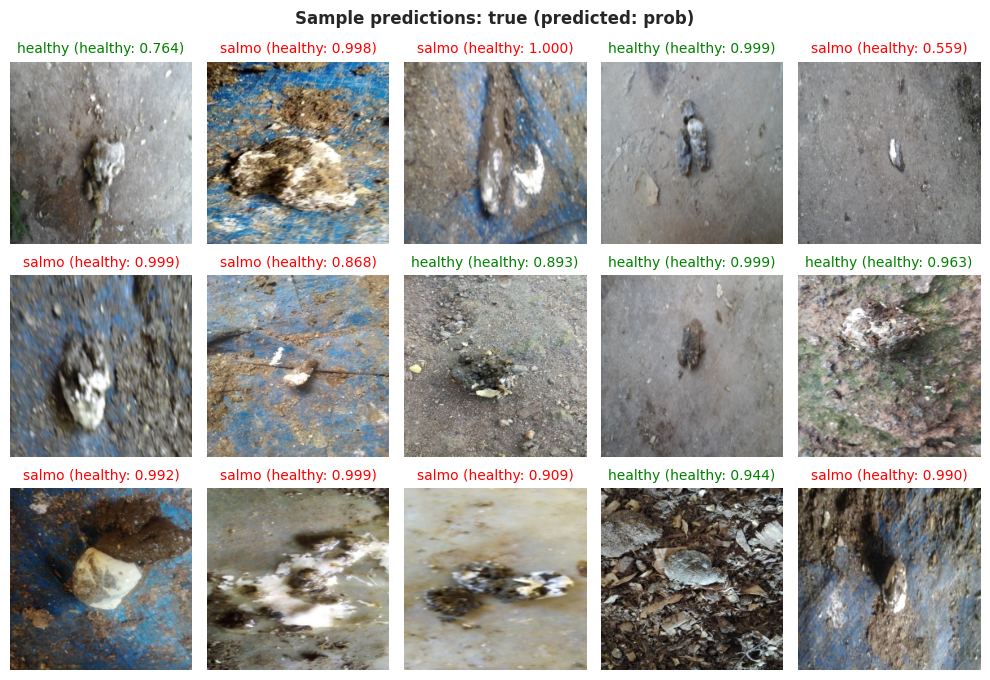

In [ ]:
# Cargar el mejor modelo guardado en el archivo "best_model.keras"
best_resnet50_model = load_model("best_resnet50_model.keras")

# Get probabilities and predictions labels for test images
y_prob = best_resnet50_model.predict(test_generator, verbose=0)
y_hat = np.argmax(y_prob, axis=1)

# Define class names
class_names = ['healthy', 'salmo']

# Create figure and subplots
fig, axs = plt.subplots(3, 5, figsize=(10, 7))
axs = axs.ravel()

# Choose random images from test set
indices = np.random.choice(len(test_generator.filenames), size=15, replace=False)

# Loop through images and display them with their predicted and true labels
for i, index in enumerate(indices):
    # Get image path and load image
    img_path = os.path.join(test_dir, test_generator.filenames[index])
    img = mpimg.imread(img_path)

    # Get true label of image
    if 'healthy' in os.path.basename(img_path):
        true_label = 'healthy'
    else:
        true_label = 'salmo'


    # Get predicted label of image
    pred_label = class_names[y_hat[index]]
    pred_prob = y_prob[index][y_hat[index]]
    pred_label = 'salmo' if pred_label == 1 else 'healthy'

    # Display image in corresponding subplot
    ax = axs[i]
    ax.imshow(img)
    ax.set_title(f"{true_label} ({pred_label}: {pred_prob:.3f})", color="green" if pred_label == true_label else "red", fontsize=10)
    ax.axis('off')

# Add title to figure
fig.suptitle('Sample predictions: true (predicted: prob)', weight='bold', fontsize=12)
plt.tight_layout()
plt.show();

# Best model info

In [ ]:
# Load best_model.keras object
best_base_model = load_model('best_resnet50_model.keras')
best_base_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 59,419,656 (226.67 MB)

 Trainable params: 17,402,370 (66.38 MB)

 Non-trainable params: 7,212,544 (27.51 MB)

 Optimizer params: 34,804,742 (132.77 MB)